In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#from google.colab.patches import cv2_imshow
import os

%matplotlib inline

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision

import torchvision.models as models

from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

In [2]:
import torch

print(torch.version.cuda)

11.8


In [3]:
ddsm_folder = "D:\Breastcancer_Resnet101\DDSM Dataset"
ddsm = glob.glob(ddsm_folder + "/**/*.png", recursive=True)

inbreast_folder = "D:\Breastcancer_Resnet101\INbreast Dataset"
inbreast = glob.glob(inbreast_folder + "/**/*.png", recursive=True)

mias_folder = "D:\Breastcancer_Resnet101\MIAS Dataset"
mias = glob.glob(mias_folder + "/**/*.png", recursive=True)

all_datasets_combine_folder = "D:\Breastcancer_Resnet101\INbreast+MIAS+DDSM Dataset"
all_datasets_combine = glob.glob(
    all_datasets_combine_folder + "/**/*.png", recursive=True
)

In [4]:
print(
    f"DDSM total dataset samples: {len(ddsm)}\n"
    f"INBreast total dataset samples: {len(inbreast)}\n"
    f"MIAS total dataset samples: {len(mias)}\n"
    f"DDSM+INBreast+MIAS total dataset samples: {len(all_datasets_combine)}"
)

DDSM total dataset samples: 13128
INBreast total dataset samples: 7632
MIAS total dataset samples: 3816
DDSM+INBreast+MIAS total dataset samples: 24576


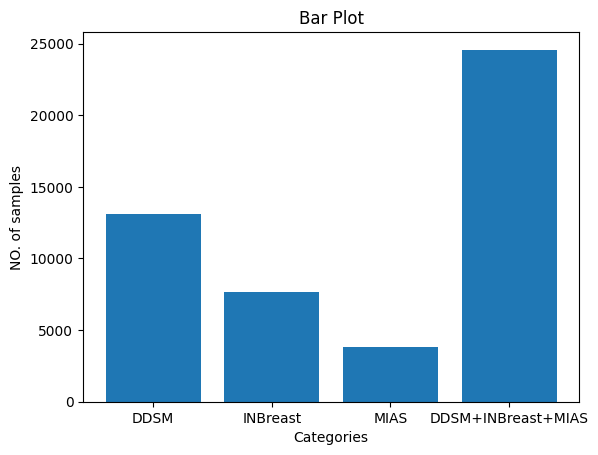

In [5]:
plt.bar(
    ["DDSM", "INBreast", "MIAS", "DDSM+INBreast+MIAS"],
    [len(ddsm), len(inbreast), len(mias), len(all_datasets_combine)],
)
# Set labels and title
plt.xlabel("Categories")
plt.ylabel("NO. of samples")
plt.title("Bar Plot")

# Show the plot
plt.show()

DDSM Image
Label of Image is: Benign Masses


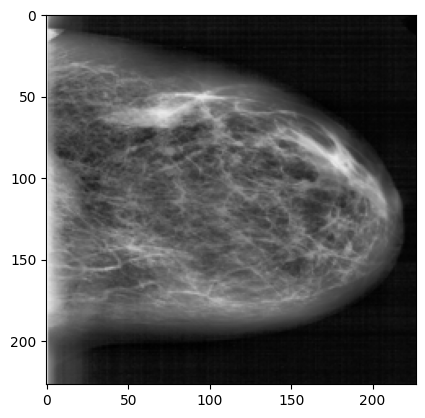

INBreast Image
Label of Image is: Malignant Masses


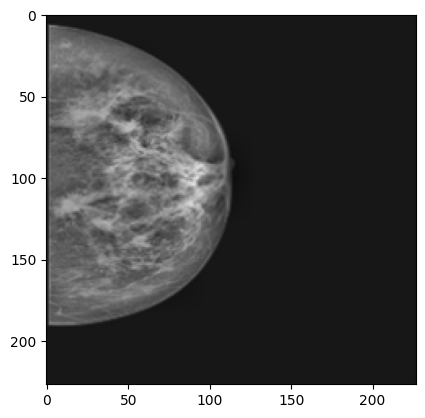

MIAS Image
Label of Image is: Benign Masses


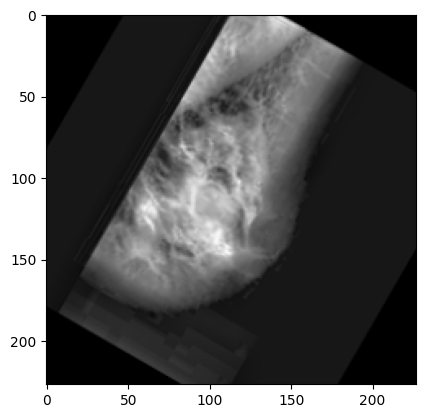

In [6]:
# Sample file paths
ddsm = ["D:\Breastcancer_Resnet101\DDSM Dataset\Benign Masses\D1_A_1177_1.RIGHT_CC (2).png"]
inbreast = ["INbreast Dataset/Malignant Masses/20586934 (2).png"]
mias = ["D:\Breastcancer_Resnet101\MIAS Dataset\Benign Masses\mdb001 (2).png"]

for i in range(1):
    # DDSM Image
    ddsm_img = cv2.imread(ddsm[i])
    ddsm_label = os.path.basename(os.path.dirname(ddsm[i]))
    print("DDSM Image\n" f"Label of Image is: {ddsm_label}")
    plt.imshow(cv2.cvtColor(ddsm_img, cv2.COLOR_BGR2RGB))
    plt.show()

    # INBreast Image
    inbreast_img = cv2.imread(inbreast[i])
    inbreast_label = os.path.basename(os.path.dirname(inbreast[i]))
    print("INBreast Image\n" f"Label of Image is: {inbreast_label}")
    plt.imshow(cv2.cvtColor(inbreast_img, cv2.COLOR_BGR2RGB))
    plt.show()

    # MIAS Image
    mias_img = cv2.imread(mias[i])
    mias_label = os.path.basename(os.path.dirname(mias[i]))
    print("MIAS Image\n" f"Label of Image is: {mias_label}")
    plt.imshow(cv2.cvtColor(mias_img, cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
model = models.resnet101(pretrained=True)

d:\Breastcancer_Resnet101\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Breastcancer_Resnet101\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
total_layers = len(list(model.parameters()))
freeze_layers = int(0.75 * total_layers)  # 75% of the layers to freeze

# Freeze the layers
for i, param in enumerate(model.parameters()):
    if i < freeze_layers:
        param.requires_grad = False

In [22]:
num_classes = 2

# Replace the last fully connected layer
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

DDSM Image
Label of Image is: Benign Masses
Shape of Image is: (227, 227, 3)


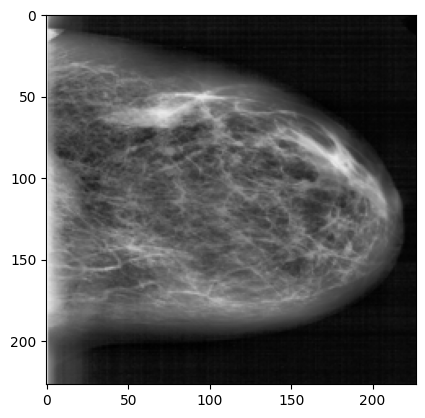

In [23]:
ddsm_img = cv2.imread(ddsm[0])
ddsm_label = os.path.basename(os.path.dirname(ddsm[0]))
print(
    "DDSM Image\n"
    f"Label of Image is: {ddsm_label}\n"
    f"Shape of Image is: {ddsm_img.shape}"
)
plt.imshow(cv2.cvtColor(ddsm_img, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
ddsm_benign = "D:\Breastcancer_Resnet101\DDSM Dataset\Benign Masses"
ddsm_benign_ = glob.glob(ddsm_benign + "/*.png", recursive=True)

ddsm_malignant = "D:\Breastcancer_Resnet101\DDSM Dataset\Malignant Masses"
ddsm_malignant_ = glob.glob(ddsm_malignant + "/*.png", recursive=True)

In [25]:
print(
    f"DDSM_BENIGN samples: {len(ddsm_benign_)}\n"
    f"DDSM_MALIGNANT samples: {len(ddsm_malignant_)}"
)

DDSM_BENIGN samples: 5970
DDSM_MALIGNANT samples: 7158


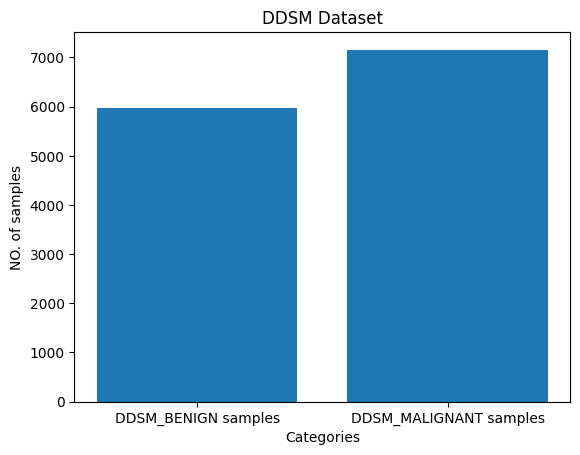

In [26]:
plt.bar(
    ["DDSM_BENIGN samples", "DDSM_MALIGNANT samples"],
    [5970, 7158],
)


# Set labels and title

plt.xlabel("Categories")

plt.ylabel("NO. of samples")

plt.title("DDSM Dataset")


# Show the plot

plt.show()

In [27]:

root_folder_s = "D:\Breastcancer_Resnet101\DDSM Dataset"
transform_without_normalization_s = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)
train_dataset_s = ImageFolder(
    root=root_folder_s, transform=transform_without_normalization_s
)
train_dataloader_s = DataLoader(train_dataset_s, batch_size=64, shuffle=True)
mean_s = 0.0
std_s = 0.0
total_samples_s = 0

for images_s, _ in train_dataloader_s:
    batch_samples_s = images_s.size(0)
    images_s = images_s.view(batch_samples_s, images_s.size(1), -1)
    mean_s += images_s.mean(2).sum(0)
    std_s += images_s.std(2).sum(0)
    total_samples_s += batch_samples_s

mean_s /= total_samples_s
std_s /= total_samples_s

print("Mean:", mean_s)
print("Standard Deviation:", std_s)

Mean: tensor([0.2658, 0.2658, 0.2658])
Standard Deviation: tensor([0.2185, 0.2185, 0.2185])


In [32]:

root_folder = "D:\Breastcancer_Resnet101\DDSM Dataset"
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize the image to a specific size
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(
            mean=[0.2658, 0.2658, 0.2658], std=[0.2185, 0.2185, 0.2185]
        ),  # Normalize the image
    ]
)

dataset_ddsm = ImageFolder(root=root_folder, transform=transform)

train_size_ = int(0.8 * len(dataset_ddsm))  # 80% for training
test_size = len(dataset_ddsm) - train_size_  # Remaining 20% for validation
train_dataset, test_dataset_ddsm = torch.utils.data.random_split(
    dataset_ddsm, [train_size_, test_size]
)
train_size = int(0.9 * len(train_dataset))  # 80% for training
valid_size = len(train_dataset) - train_size  # Remaining 20% for validation
train_dataset_ddsm, valid_dataset_ddsm = torch.utils.data.random_split(
    train_dataset, [train_size, valid_size]
)
train_dataloader_ddsm = DataLoader(train_dataset_ddsm, batch_size=64, shuffle=True)
valid_dataloader_ddsm = DataLoader(valid_dataset_ddsm, batch_size=32, shuffle=False)
test_dataloader_ddsm = DataLoader(test_dataset_ddsm, batch_size=32, shuffle=False)

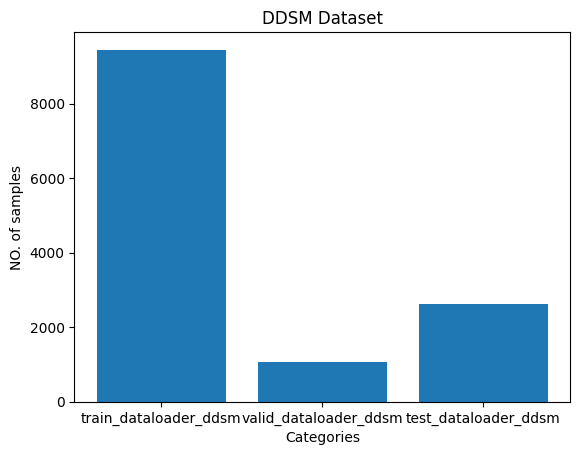

In [33]:
plt.bar(
    ["train_dataloader_ddsm", "valid_dataloader_ddsm", "test_dataloader_ddsm"],
    [
        len(train_dataloader_ddsm.dataset),
        len(valid_dataloader_ddsm.dataset),
        len(test_dataloader_ddsm.dataset),
    ],
)

# Set labels and title
plt.xlabel("Categories")
plt.ylabel("NO. of samples")
plt.title("DDSM Dataset")

# Show the plot
plt.show()

In [34]:
# Set the device to run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.to(device=device)


def train(num_epoch, model):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(0, num_epoch):
        model.train()
        loop = tqdm(
            enumerate(train_dataloader_ddsm), total=len(train_dataloader_ddsm.dataset)
        )
        running_loss = 0.0
        corrects = 0
        total = 0

        for batch_idx, (data, targets) in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)

            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(scores, 1)

            running_loss += loss.item() * data.size(0)
            corrects += torch.sum(preds == targets.data)
            total += targets.size(0)

            loop.set_description(f"Epoch {epoch+1}/{num_epoch}")
            
        epoch_loss = running_loss / len(train_dataloader_ddsm.dataset)
        train_accuracy = corrects.double() / total
        model.eval()
        val_loss = 0.0
        val_corrects = 0.0
        with torch.no_grad():
            for val_data, val_targets in valid_dataloader_ddsm:
                val_data = val_data.to(device=device)
                val_targets = val_targets.to(device=device)
                val_scores = model(val_data)
                val_batch_loss = criterion(val_scores, val_targets)
                val_loss += val_batch_loss.item() * val_data.size(0)
                _, val_preds = torch.max(val_scores, 1)
                val_corrects += torch.sum(val_preds == val_targets.data)

        val_loss = val_loss / len(valid_dataloader_ddsm.dataset)
        val_accuracy = val_corrects.double() / len(valid_dataloader_ddsm.dataset)

        print(
            "Training Loss: {:.4f}".format(epoch_loss),
            "Validation Loss: {:.4f}".format(val_loss),
        )
        print(
            "Train Accuracy: {:.4f}".format(train_accuracy),
            "Validation Accuracy: {:.4f}".format(val_accuracy),
        )

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

        # Save model
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            "final_model.pth"
        )

    # Plotting curves
    plt.plot(range(1, num_epoch + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epoch + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    plt.plot(range(1, num_epoch + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epoch + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

  0%|          | 0/9451 [00:00<?, ?it/s]

Epoch 1/5:   2%|▏         | 148/9451 [04:18<4:30:33,  1.74s/it] 


Training Loss: 0.0261 Validation Loss: 0.4439
Train Accuracy: 0.9879 Validation Accuracy: 0.9429


Epoch 2/5:   2%|▏         | 148/9451 [04:43<4:56:28,  1.91s/it] 


Training Loss: 0.0045 Validation Loss: 0.0003
Train Accuracy: 0.9990 Validation Accuracy: 1.0000


Epoch 3/5:   2%|▏         | 148/9451 [05:05<5:20:07,  2.06s/it] 


Training Loss: 0.0004 Validation Loss: 0.0000
Train Accuracy: 0.9999 Validation Accuracy: 1.0000


Epoch 4/5:   2%|▏         | 148/9451 [03:05<3:14:04,  1.25s/it]


Training Loss: 0.0001 Validation Loss: 0.0000
Train Accuracy: 1.0000 Validation Accuracy: 1.0000


Epoch 5/5:   2%|▏         | 148/9451 [03:01<3:09:39,  1.22s/it]


Training Loss: 0.0001 Validation Loss: 0.0000
Train Accuracy: 1.0000 Validation Accuracy: 1.0000


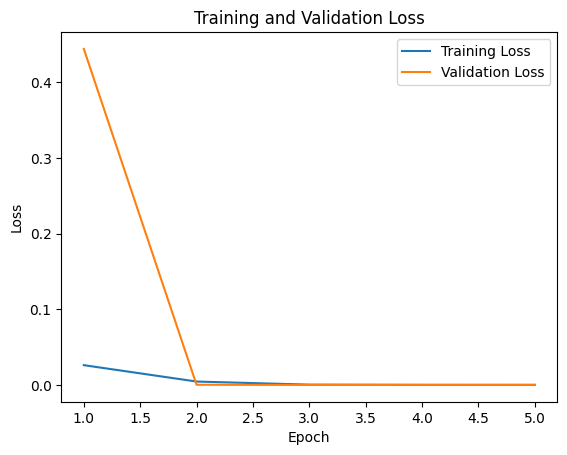

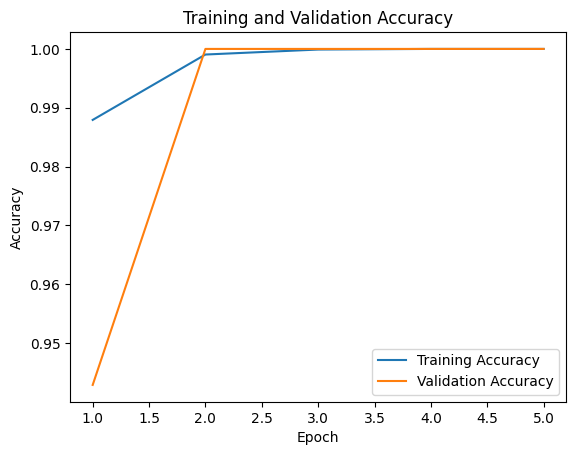

In [36]:
train(5, model)

In [41]:
checkpoint = torch.load("D:/Breastcancer_Resnet101/final_model.pth")  # Load the saved checkpoint file

model = models.resnet101(pretrained=True)  # Create an instance of the model
model.fc = torch.nn.Linear(model.fc.in_features, 2)

model.load_state_dict(checkpoint['model_state_dict'])  # Load the model's state dictionary

optimizer = optim.SGD(model.parameters(), lr=0.001)  # Create an instance of the optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Load the optimizer's state dictionary

In [42]:
def test(test_loader, model):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0

    true_output = []
    pred_output = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            true_output.extend(y.tolist())

            output = model(x)
            _, predictions = torch.max(output, 1)
            pred_output.extend(predictions.tolist())

            correct += (predictions == y).sum().item()
            test_loss += criterion(output, y)

            # Display the image, predicted label, and actual label
            for i in range(len(x)):
                if i % 1000 == 0:
                    image = x[i].cpu().numpy()
                    predicted_label = predictions[i].item()
                    actual_label = y[i].item()

                    plt.imshow(np.transpose(image, (1, 2, 0)))
                    plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")

                    plt.show()

    test_loss /= len(test_loader.dataset)

    print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
    len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")

    Confusion_matrix = confusion_matrix(true_output, pred_output)
    report = classification_report(true_output, pred_output)
    F1_score = f1_score(true_output, pred_output, average='macro')

    print('F1 Score is: {}'.format(F1_score))
    print('Classification_Report Score is: {}'.format(report))


    fig = plt.figure(figsize=(15,5))
    sns.heatmap(Confusion_matrix, annot=True, cmap='Blues')
    plt.show()


In [ ]:
test(test_dataloader_ddsm, model)